In [1]:
# %%
import os
import sys

from matplotlib import animation
sys.path.append("/home/mbortkie/repos/crl_subgoal/src")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
# %%
import functools
import os
import distrax


import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
import matplotlib.pyplot as plt
from impls.utils.networks import GCDiscreteActor
import copy
import numpy as np
import IPython.display as display




In [2]:
def display_gif(env, timesteps, idx):
    grid_size = timesteps.grid.shape[-2:]
    fig, ax = plt.subplots(figsize=grid_size)

    animate = functools.partial(env.animate, ax, jax.tree_util.tree_map(lambda x: x[:,idx:].swapaxes(1, 0), timesteps), img_prefix=os.path.join(ROOT_DIR, 'assets'))

    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=EPISODE_LENGTH, interval=80, repeat=False)

    # Save as GIF
    gif_path = f"/tmp/block_moving_epoch.gif"
    anim.save(gif_path, writer='pillow')
    plt.close()


    # Visualize the GIF in the notebook
    display.display(display.Image(filename=gif_path))

def plot_q_value_difference(agent, states, goals, actions, episode_length, num_envs):
    """
    Plot the absolute difference between Q1 and Q2 values over timesteps.
    
    Parameters:
    -----------
    agent : Agent
        The agent with the critic network
    states : Array
        Trajectory states with shape (episode_length, num_envs, ...)
    goals : Array
        Trajectory goals with shape (episode_length, num_envs, ...)
    actions : Array
        Trajectory actions with shape (episode_length, num_envs)
    episode_length : int
        Length of episodes
    num_envs : int
        Number of parallel environments
    """
    # Reshape trajectories to combine episode and environment dimensions
    traj_states_flat = states.reshape((states.shape[0] * states.shape[1], -1))
    traj_goals_flat = goals.reshape((goals.shape[0] * goals.shape[1], -1))
    traj_actions_flat = actions.reshape((actions.shape[0] * actions.shape[1]))
    
    # Get Q-values from critic network
    q1, q2 = agent.network.select('critic')(traj_states_flat, traj_goals_flat, traj_actions_flat)
    
    # Reshape back to (episode_length, num_envs)
    q1 = q1.reshape((episode_length, num_envs))
    q2 = q2.reshape((episode_length, num_envs))
    
    # Compute mean and standard error of absolute difference
    q_diff = jnp.mean(jnp.abs(q1 - q2), axis=1)
    q_diff_std_error = jnp.std(jnp.abs(q1 - q2), axis=1) / jnp.sqrt(q1.shape[1])
    
    # Plot
    plt.plot(q_diff, label='|q1 - q2|')
    plt.fill_between(np.arange(len(q_diff)), q_diff - q_diff_std_error, 
                     q_diff + q_diff_std_error, alpha=0.2)
    plt.xlabel('Timestep')
    plt.ylabel('Absolute Difference')
    plt.title('Distance between q1 and q2 over Timesteps')
    plt.legend()
    plt.show()


In [3]:
# %%
RANGE_GENERALIZATION = [1,2,3,4,5,6,7,9,11]
EPISODE_LENGTH = 100
NUM_ENVS = 1024
CHECKPOINT = 50
RUN_NAME = f"DQN{CHECKPOINT}_investigation"
NUM_BOXES = 1
# MODEL_PATH = f"/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20251018_180741/runs/dqn_additional_loss_simple_te-1.38_{NUM_BOXES}_grid_4_ep_len__filter_"
# MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20251016_222226/runs/dqn_1.38_bilinear_2_grid_4" #for bilinear remember to change critic_def in dqn.py
MODEL_PATH = f"/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_{NUM_BOXES}_grid_4_ep_len__filter_"
# MODEL_PATH = f"/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044157/runs/dqn_1.38_{NUM_BOXES}_grid_4_ep_len__filter_quarter"
EPOCHS = 51
EVAL_EVERY = 10
FIGURES_PATH = f"/home/mbortkie/repos/crl_subgoal/notebooks/figures/{RUN_NAME}"
GIF_PATH = f"{FIGURES_PATH}/gifs"
os.makedirs(FIGURES_PATH, exist_ok=True)
# os.makedirs(GIF_PATH, exist_ok=True)


In [4]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=4,
        number_of_boxes_min=NUM_BOXES,
        number_of_boxes_max=NUM_BOXES,
        number_of_moving_boxes_max=NUM_BOXES
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [5]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.agent.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    "observations": dummy_timestep.grid.reshape(1, -1),  # Add batch dimension
    "next_observations": dummy_timestep.grid.reshape(1, -1),
    "actions": jnp.ones((1,), dtype=jnp.int8)
    * (env._env.action_space - 1),  # it should be the maximal value of action space
    "rewards": jnp.ones((1,), dtype=jnp.int8),
    "masks": jnp.ones((1,), dtype=jnp.int8),
    "value_goals": dummy_timestep.grid.reshape(1, -1),
    "actor_goals": dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_50.pkl


In [6]:
# Create env once again with correct config and collect data
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

# %%
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)

2025-11-05 20:11:38.397573: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [7]:
jitted_flatten_batch = jax.jit(jax.vmap(flatten_batch, in_axes=(None, None, 0, 0)), static_argnums=(0, 1))
jitted_create_batch = functools.partial(
    create_batch,
    gamma=config.exp.gamma,
    # use_targets=config.exp.use_targets,
    use_targets=True,
    use_future_and_random_goals=config.exp.use_future_and_random_goals,
    jitted_flatten_batch=jitted_flatten_batch,
    use_discounted_mc_rewards=config.agent.use_discounted_mc_rewards,
)

# S G different quadrants

In [8]:
import numpy as np

def gen_matrices(n, quarter=1, k=2, seed=None, shape=(6,6)):
    """
    Generate `n` random 6x6 matrices (dtype=int8).
    - `quarter` in {1,2,3,4} selects the 3x3 quadrant:
        1: top-left, 2: top-right, 3: bottom-left, 4: bottom-right
    - `k` is the number of ones to place (1..9) inside that 3x3 quarter (no duplicates).
    - Places a single 3 somewhere else (never on a cell that is 1).
    Returns array of shape (n, 6, 6), dtype=np.int8.
    """
    if quarter not in (1, 2, 3, 4):
        raise ValueError("quarter must be 1,2,3 or 4")
    if not (1 <= k <= shape[0]*shape[1]):
        raise ValueError(f"k must be between 1 and {shape[0]*shape[1]} (inclusive)")
    rng = np.random.default_rng(seed)
    qmap = {1: (0, 0), 2: (0, shape[1]//2), 3: (shape[0]//2, 0), 4: (shape[0]//2, shape[1]//2)}
    sr, sc = qmap[quarter]

    out = np.zeros((n, *shape), dtype=np.int8)
    for i in range(n):
        # choose k distinct positions inside the quarter 
        sel = rng.choice(shape[0]*shape[1]//4, size=k, replace=False)
        rows = sr + sel // (shape[0]//2)
        cols = sc + sel % (shape[1]//2)
        out[i, rows, cols] = 1

        # choose one location for the value 3 that is not already 1
        free_positions = np.flatnonzero(out[i].ravel() == 0)
        pos3 = rng.choice(free_positions)
        out[i].ravel()[pos3] = 3 # place agent

    return out


In [9]:
NUM_SAMPLES = 1000
mats_q1 = gen_matrices(NUM_SAMPLES, quarter=1, k=NUM_BOXES, seed=43, shape=(4,4))  # returns shape (NUM_SAMPLES,4,4)
mats_q2 = gen_matrices(NUM_SAMPLES, quarter=2, k=NUM_BOXES, seed=43, shape=(4,4))  # returns shape (NUM_SAMPLES,4,4)
mats_q3 = gen_matrices(NUM_SAMPLES, quarter=3, k=NUM_BOXES, seed=43, shape=(4,4))  # returns shape (NUM_SAMPLES,4,4)
mats_q4 = gen_matrices(NUM_SAMPLES, quarter=4, k=NUM_BOXES, seed=43, shape=(4,4))  # returns shape (NUM_SAMPLES,4,4)
print(mats_q1[0],"\n", mats_q2[10], "\n", mats_q3[10], "\n", mats_q4[10])

[[0 0 0 0]
 [1 0 0 0]
 [0 0 3 0]
 [0 0 0 0]] 
 [[0 0 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 3]] 
 [[0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 0 0 3]] 
 [[0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 3]]


In [10]:
mats_q1 = mats_q1.reshape(NUM_SAMPLES, -1)
mats_q2 = mats_q2.reshape(NUM_SAMPLES, -1)
mats_q3 = mats_q3.reshape(NUM_SAMPLES, -1)
mats_q4 = mats_q4.reshape(NUM_SAMPLES, -1)
mats_q1.shape

(1000, 16)

In [11]:
# Collect data for plotting
checkpoints = range(0, EPOCHS, EVAL_EVERY)

results_all = {}
for idx, (base_mat_name, base_mat) in enumerate([("mats_q1", mats_q1), ("mats_q2", mats_q2), ("mats_q3", mats_q3), ("mats_q4", mats_q4)]):
    results = {mat_name: [] for mat_name in ["mats_q1", "mats_q2", "mats_q3", "mats_q4"]}
    
    for mat_name, mat in [("mats_q1", mats_q1), ("mats_q2", mats_q2), ("mats_q3", mats_q3), ("mats_q4", mats_q4)]:
        for checkpoint in checkpoints:
            agent, config = restore_agent(example_batch, MODEL_PATH, checkpoint)
            print(f"{base_mat_name} - Checkpoint {checkpoint}")
            
            all_actions = jnp.tile(jnp.arange(6), (base_mat.shape[0], 1))  # B x 6
            qs = jax.lax.stop_gradient(jax.vmap(agent.network.select('critic'), in_axes=(None, None, 1))(base_mat, mat, all_actions)) # 6 x 2 x B
            qs = qs.mean(axis=1) # 6 x B
            q = qs.transpose(1, 0) # B x 6
            results[mat_name].append(q.mean())
            print(f"  {base_mat_name} to {mat_name}: q: {q.mean():.2f}")
        print()
    results_all[base_mat_name] = results
    


Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_0.pkl
mats_q1 - Checkpoint 0


2025-11-05 20:11:47.623017: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


  mats_q1 to mats_q1: q: -0.10
Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_10.pkl
mats_q1 - Checkpoint 10
  mats_q1 to mats_q1: q: 103.62
Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_20.pkl
mats_q1 - Checkpoint 20
  mats_q1 to mats_q1: q: 102.42
Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_30.pkl
mats_q1 - Checkpoint 30
  mats_q1 to mats_q1: q: 101.87
Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_40.pkl
mats_q1 - Checkpoint 40
  mats_q1 to mats_q1: q: 101.57
Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_50.pkl
mats_

In [12]:
results_all

{'mats_q1': {'mats_q1': [Array(-0.09644257, dtype=float32),
   Array(103.62402, dtype=float32),
   Array(102.423416, dtype=float32),
   Array(101.86882, dtype=float32),
   Array(101.56815, dtype=float32),
   Array(101.42961, dtype=float32)],
  'mats_q2': [Array(0.04396074, dtype=float32),
   Array(96.84731, dtype=float32),
   Array(95.86197, dtype=float32),
   Array(95.40677, dtype=float32),
   Array(95.1447, dtype=float32),
   Array(94.995605, dtype=float32)],
  'mats_q3': [Array(-0.09904279, dtype=float32),
   Array(97.000206, dtype=float32),
   Array(95.851715, dtype=float32),
   Array(95.36335, dtype=float32),
   Array(95.18764, dtype=float32),
   Array(94.986855, dtype=float32)],
  'mats_q4': [Array(-0.11049705, dtype=float32),
   Array(95.491455, dtype=float32),
   Array(94.21278, dtype=float32),
   Array(93.68619, dtype=float32),
   Array(93.43625, dtype=float32),
   Array(93.29579, dtype=float32)]},
 'mats_q2': {'mats_q1': [Array(-0.02339895, dtype=float32),
   Array(96.86083, 

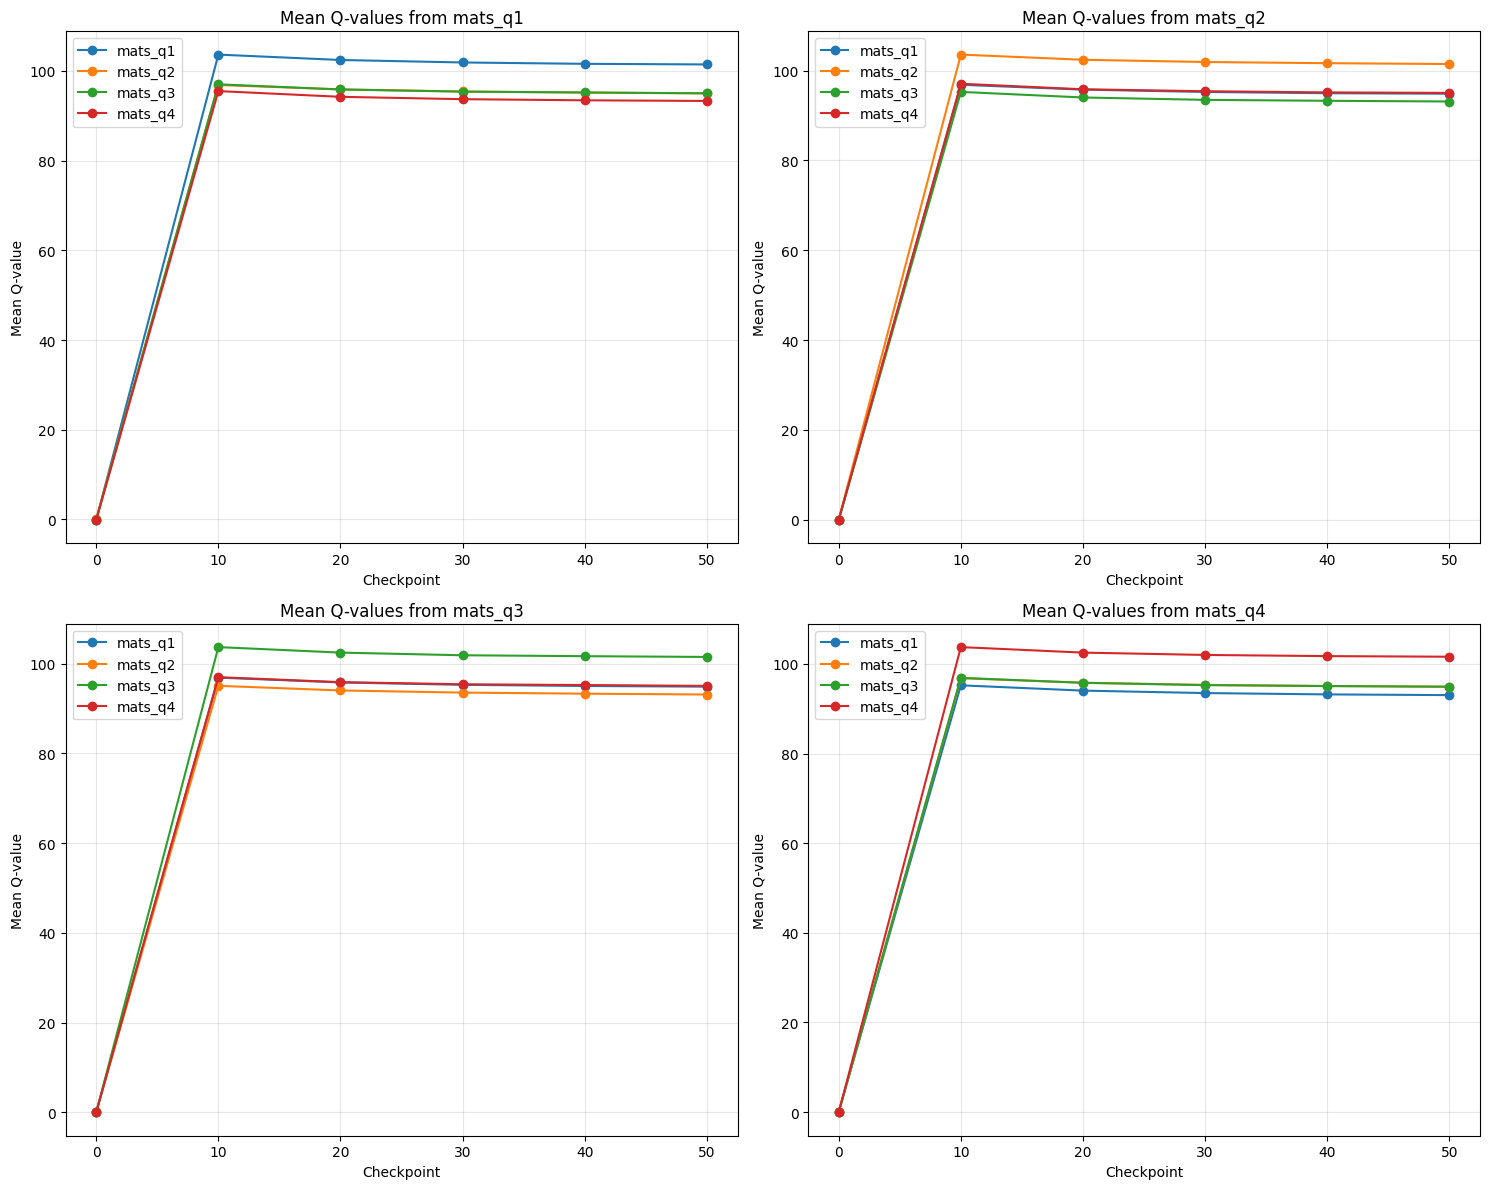

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (base_mat_name, base_mat) in enumerate([("mats_q1", mats_q1), ("mats_q2", mats_q2), ("mats_q3", mats_q3), ("mats_q4", mats_q4)]):
    
    ax = axes[idx]
    for mat_name in results.keys():
        ax.plot(list(checkpoints), results_all[base_mat_name][mat_name], marker='o', label=mat_name)
    
    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('Mean Q-value')
    ax.set_title(f'Mean Q-values from {base_mat_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Variance

In [14]:
# Collect data for plotting
checkpoints = range(0, EPOCHS, EVAL_EVERY)

results_all = {}
for idx, (base_mat_name, base_mat) in enumerate([("mats_q1", mats_q1), ("mats_q2", mats_q2), ("mats_q3", mats_q3), ("mats_q4", mats_q4)]):
    results = {mat_name: [] for mat_name in ["mats_q1", "mats_q2", "mats_q3", "mats_q4"]}
    
    for mat_name, mat in [("mats_q1", mats_q1), ("mats_q2", mats_q2), ("mats_q3", mats_q3), ("mats_q4", mats_q4)]:
        for checkpoint in checkpoints:
            agent, config = restore_agent(example_batch, MODEL_PATH, checkpoint)
            print(f"{base_mat_name} - Checkpoint {checkpoint}")
            
            all_actions = jnp.tile(jnp.arange(6), (base_mat.shape[0], 1))  # B x 6
            qs = jax.lax.stop_gradient(jax.vmap(agent.network.select('critic'), in_axes=(None, None, 1))(base_mat, mat, all_actions)) # 6 x 2 x B
            qs = qs.mean(axis=1) # 6 x B
            q = qs.transpose(1, 0) # B x 6
            results[mat_name].append(q.var())
            print(f"  {base_mat_name} to {mat_name}: q var: {q.var():.2f}")
        print()
    results_all[base_mat_name] = results
    

Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_0.pkl
mats_q1 - Checkpoint 0
  mats_q1 to mats_q1: q var: 0.56
Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_10.pkl
mats_q1 - Checkpoint 10
  mats_q1 to mats_q1: q var: 0.26
Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_20.pkl
mats_q1 - Checkpoint 20
  mats_q1 to mats_q1: q var: 0.14
Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_30.pkl
mats_q1 - Checkpoint 30
  mats_q1 to mats_q1: q var: 0.06
Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_40.pkl
mats_q1 - Checkpoint 40
  mats

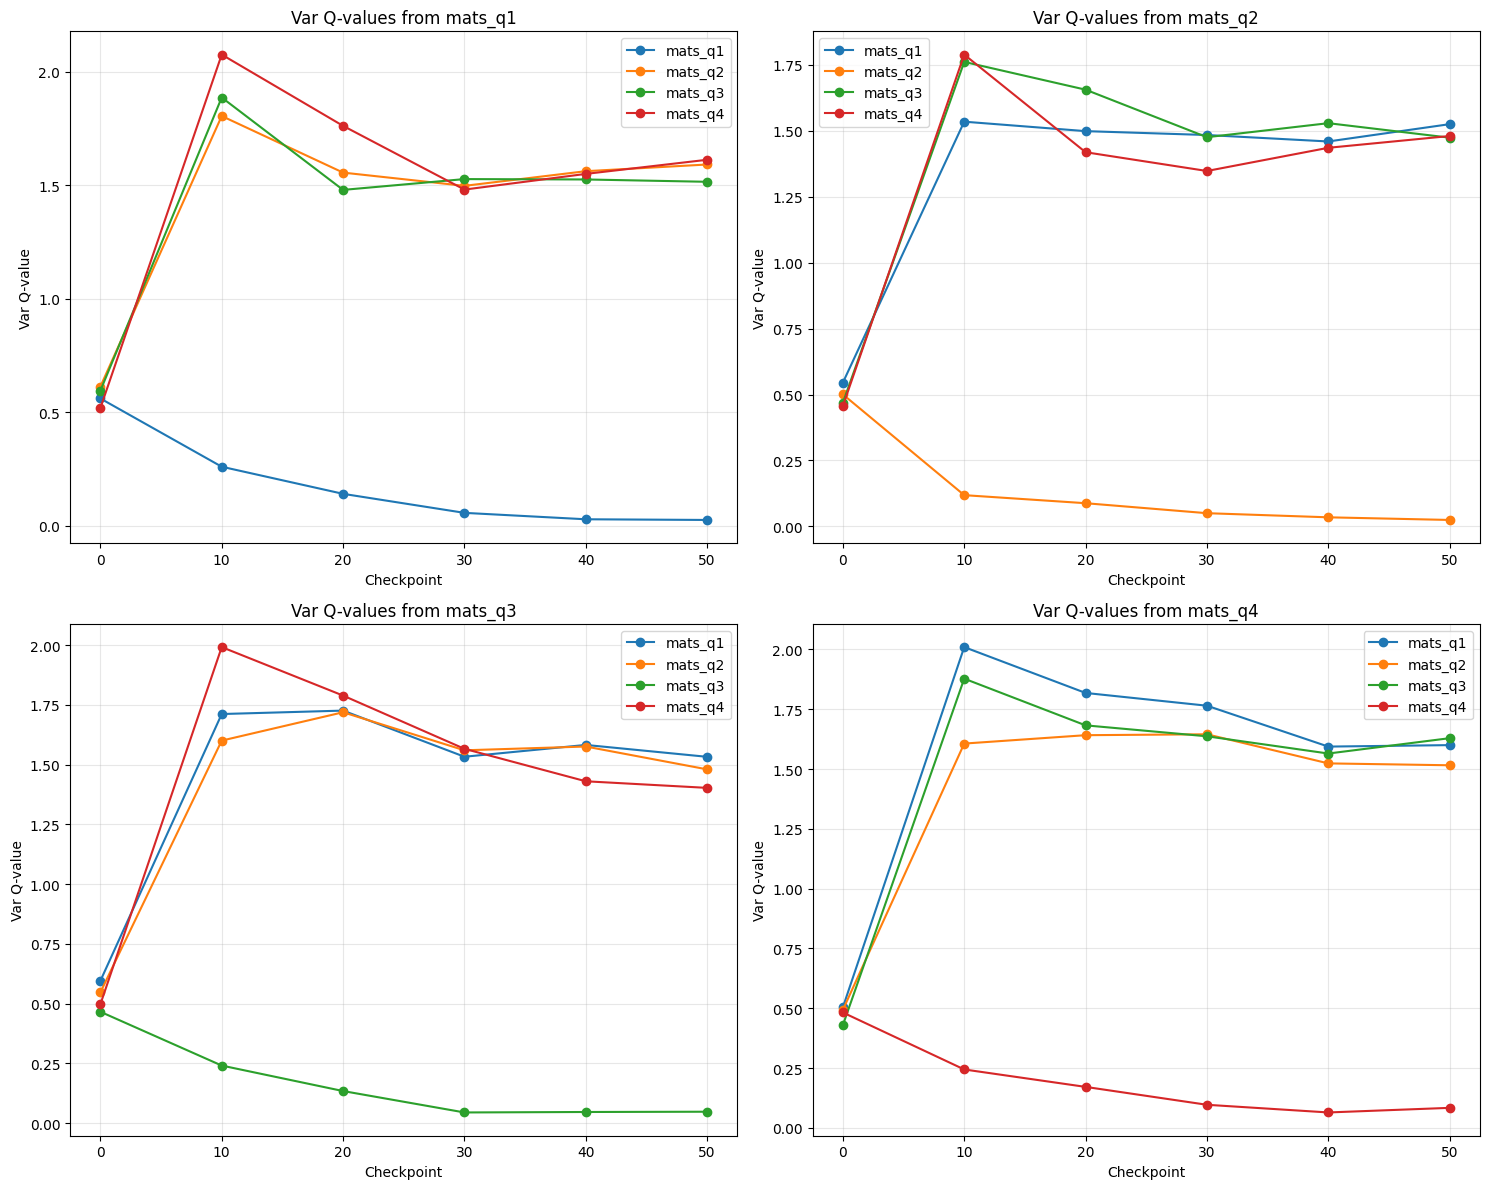

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (base_mat_name, base_mat) in enumerate([("mats_q1", mats_q1), ("mats_q2", mats_q2), ("mats_q3", mats_q3), ("mats_q4", mats_q4)]):
    
    ax = axes[idx]
    for mat_name in results.keys():
        ax.plot(list(checkpoints), results_all[base_mat_name][mat_name], marker='o', label=mat_name)
    
    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('Var Q-value')
    ax.set_title(f'Var Q-values from {base_mat_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()